In [1]:
### =-=-= LER DADOS RASTER =-=-= ###

In [2]:
# Read elevation raster
# ----------------------------
from pysheds.grid import Grid

grid = Grid.from_raster('srtm_data.tif')
dem = grid.read_raster('srtm_data.tif')


In [3]:
### =-=-= PLOTANDO DADOS =-=-= ###

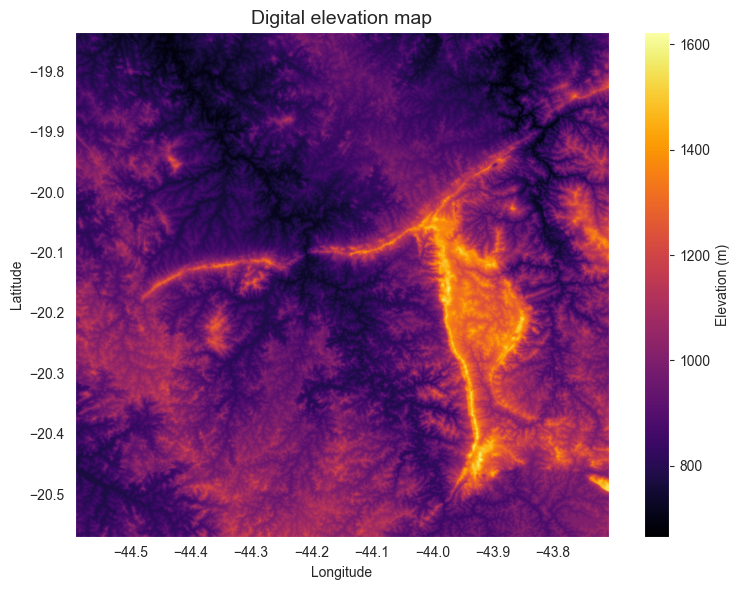

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='inferno', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [5]:
### =-=-= Condicione os dados de elevação =-=-= ###

In [6]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [7]:
### =-=-= Elevação para direção do fluxo =-=-= ### Elevação para direção do fluxo

In [8]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

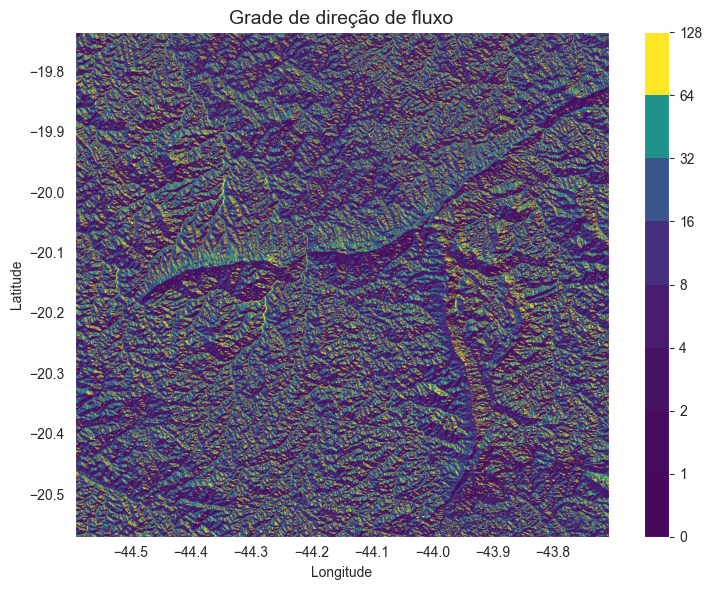

In [9]:
ig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grade de direção de fluxo', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [10]:
### =-=-= Calcular a acumulação a partir da direção do fluxo =-=-= ###

In [11]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

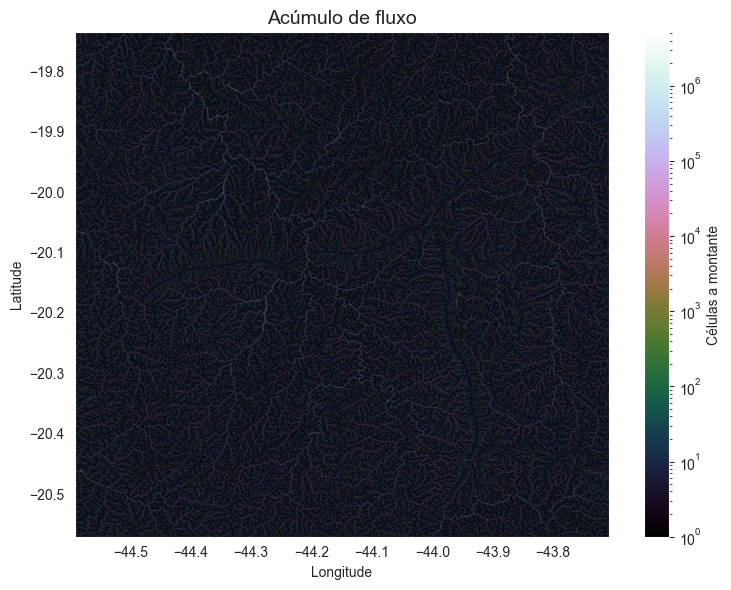

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Células a montante')
plt.title('Acúmulo de fluxo', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [13]:
### =-=-= Delinear a captação a partir da direção do fluxo =-=-= ###

In [14]:
# Delineate a catchment
# --------------------
# Ponto de saída
x, y = -44.118627, -20.316243
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                       xytype='coordinate')

In [15]:
### =-=-= Extrair a rede fluvial e calcular distância =-=-= ###

In [16]:
# Extract river network
# ---------------------
# Isso deve ser feito antes de recortar o grid para garantir que as dimensões dos arrays estão corretas.
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

# Calculate distance to outlet from each cell
# -------------------------------------------
# Isso também deve ser feito no grid completo para evitar problemas de desempenho e erros de dimensão.
# A função estava executando infinitamente porque operava em um grid recortado com um array de direção de fluxo (fdir) não recortado.
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

In [17]:
### =-=-= Recortar dados para a bacia hidrográfica =-=-= ###

In [18]:
# Agora, recorte o grid para a área da bacia hidrográfica
grid.clip_to(catch)

# Crie visualizações (views) recortadas dos arrays de dados.
# Isso não copia os dados na memória, apenas cria uma nova "janela" para os dados existentes.
catch_view = grid.view(catch)
fdir_view = grid.view(fdir)
acc_view = grid.view(acc)
dist_view = grid.view(dist)

In [19]:
### =-=-= PLOTANDO REDE FLUVIAL NA BACIA RECORTADA =-=-= ###

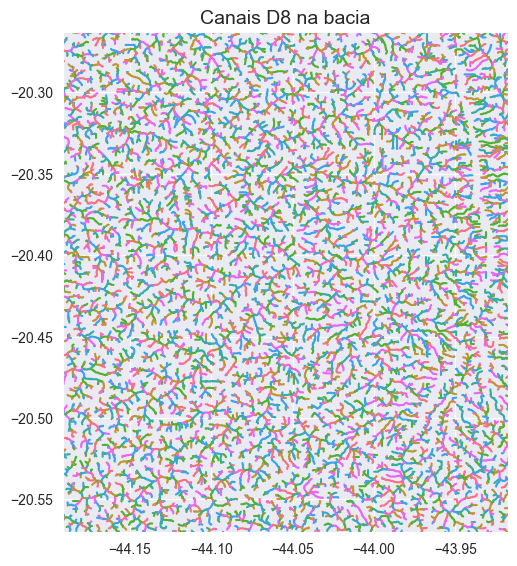

In [20]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

# Use o BBOX do grid recortado para definir os limites do plot
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

# As coordenadas dos rios estão no sistema de coordenadas original e serão plotadas corretamente dentro dos novos limites
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title('Canais D8 na bacia', size=14)

In [21]:
### =-=-= PLOTANDO DISTÂNCIA DO FLUXO NA BACIA RECORTADA =-=-= ###

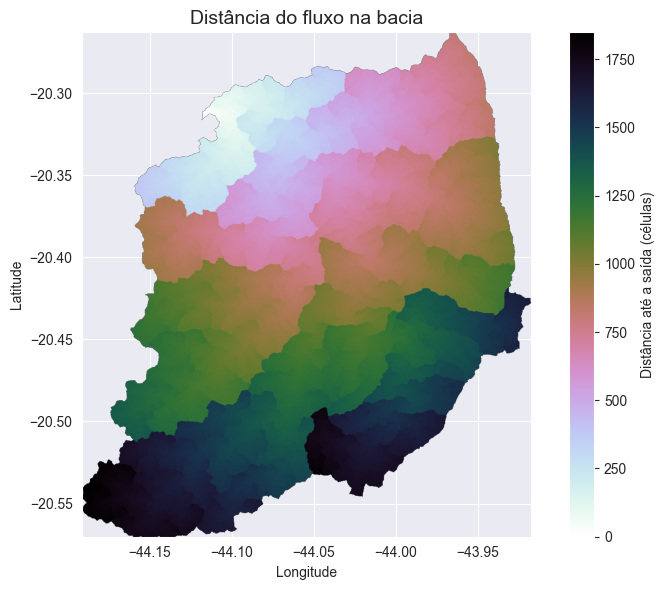

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
# Use a visualização recortada (dist_view) e a extensão do grid recortado para plotar
im = ax.imshow(dist_view, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distância até a saída (células)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distância do fluxo na bacia', size=14)
plt.tight_layout()


In [23]:
### =-=-= EXPORTANDO CAMADAS SRTM COMPLETAS =-=-= ###
# Esta seção permanece a mesma, pois exporta os dados completos antes do recorte.
# Para garantir que temos as camadas de base para todo o SRTM,
# vamos exportar a direção do fluxo (fdir) e a acumulação (acc)
# antes de recortar para a bacia hidrográfica.
from pysheds.grid import Grid
import numpy as np

# Criamos um novo objeto Grid para garantir que a extensão espacial está correta.
grid_completo = Grid.from_raster('srtm_data.tif')

# Exportando fdir (Direção de Fluxo) do SRTM completo
# Validando o tipo de dado para fdir
print(f"Tipo de dado de fdir: {fdir.dtype}")
if fdir.max() < 256:
    fdir_export_completo = fdir.astype(np.uint8)
    print("Convertendo fdir para Uint8.")
else:
    fdir_export_completo = fdir.astype(np.uint16)
    print("fdir requer Uint16 ou maior.")
grid_completo.to_raster(fdir_export_completo, 'srtm_flow_direction.tif')
print("Exportado: srtm_flow_direction.tif")

# Exportando acc (Acumulação) do SRTM completo
# Validando o tipo de dado para acc
print(f"Tipo de dado de acc: {acc.dtype}")
print(f"Valor máximo em acc: {acc.max()}")
if acc.max() < 65536:
    acc_export_completo = acc.astype(np.uint16)
    print("Convertendo acc para Uint16.")
else:
    # Usar float32 para valores grandes de acumulação
    acc_export_completo = acc.astype(np.float32)
    print("acc é muito grande para Uint16, usando float32.")
grid_completo.to_raster(acc_export_completo, 'srtm_flow_accumulation.tif')
print("Exportado: srtm_flow_accumulation.tif")


Tipo de dado de fdir: int64
Convertendo fdir para Uint8.
Exportado: srtm_flow_direction.tif
Tipo de dado de acc: float64
Valor máximo em acc: 5137936.0
acc é muito grande para Uint16, usando float32.
Exportado: srtm_flow_accumulation.tif


In [24]:
### =-=-= EXPORTANDO CAMADAS RECORTADAS PARA A BACIA =-=-= ###
import json
import numpy as np

# Definindo valores nodata seguros para cada tipo de dado
nodata_uint8 = 255
nodata_uint16 = 65535
nodata_float32 = -9999.0  # Usar um float explicitamente

# --- Validação e exportação de fdir_view (Direção do Fluxo) ---
print(f"Tipo de dado de fdir_view: {fdir_view.dtype}")
nodata_fdir = None
if fdir_view.max() < 256:
    fdir_export = fdir_view.astype(np.uint8)
    nodata_fdir = nodata_uint8
    print("Convertendo fdir_view para Uint8.")
else:
    fdir_export = fdir_view.astype(np.uint16)
    nodata_fdir = nodata_uint16
    print("fdir_view requer Uint16 ou maior.")

# CORREÇÃO: Especificar nodata compatível com o dtype
grid.to_raster(fdir_export, 'flow_dirr.tif', nodata=nodata_fdir)
print("Exportado: flow_dirr.tif")


# --- Validação e exportação de acc_view (Acumulação) ---
print(f"Tipo de dado de acc_view: {acc_view.dtype}")
print(f"Valor máximo em acc_view: {acc_view.max()}")
nodata_acc = None
if acc_view.max() < 65536:
    acc_export = acc_view.astype(np.uint16)
    nodata_acc = nodata_uint16
    print("Convertendo acc_view para Uint16.")
else:
    acc_export = acc_view.astype(np.float32)
    nodata_acc = nodata_float32
    print("acc_view é muito grande para Uint16, usando float32.")

# CORREÇÃO: Especificar nodata compatível com o dtype
grid.to_raster(acc_export, 'acc.tif', nodata=nodata_acc)
print("Exportado: acc.tif")


# --- Validação e exportação de dist_view (Distância do Fluxo) ---
print(f"Tipo de dado de dist_view: {dist_view.dtype}")
print(f"Valor máximo em dist_view: {dist_view.max()}")

# O código original estava forçando float32, vamos manter isso
dist_export = dist_view.astype(np.float32)
print("Convertendo dist_view para float32.")

# CORREÇÃO: Especificar nodata compatível com float32
# Usando -9999.0 em vez de np.nan, pois np.nan falhou na validação.
grid.to_raster(dist_export, 'flow_dist.tif', nodata=nodata_float32)
print("Exportado: flow_dist.tif")


# --- Exportando branches (Rede Fluvial) como GeoJSON ---
# O objeto 'branches' contém as geometrias completas e não precisa ser alterado.
with open('cursos_d_agua.geojson', 'w') as f:
    json.dump(branches, f, indent=4)

print("Exportado: cursos_d_agua.geojson")

Tipo de dado de fdir_view: int64
Convertendo fdir_view para Uint8.
Exportado: flow_dirr.tif
Tipo de dado de acc_view: float64
Valor máximo em acc_view: 744791.0
acc_view é muito grande para Uint16, usando float32.
Exportado: acc.tif
Tipo de dado de dist_view: float64
Valor máximo em dist_view: nan
Convertendo dist_view para float32.
Exportado: flow_dist.tif
Exportado: cursos_d_agua.geojson
